In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn import tree

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crowdedness-at-the-campus-gym/data.csv


In [18]:
data = pd.read_csv('../input/crowdedness-at-the-campus-gym/data.csv') # On charge le csv contenant les données
sum_people = 0
count = 0
for value in data['number_people']:
    sum_people = sum_people + value
    count = count + 1
average_usercount = sum_people/count
print(sum_people," utilisateurs pour ",count," échantillons de donnés récoltés pour une moyenne de ",average_usercount," utilisateurs à tout moment")

1807847  utilisateurs pour  62184  échantillons de donnés récoltés pour une moyenne de  29.072542776276855  utilisateurs à tout moment


In [19]:
data

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17
...,...,...,...,...,...,...,...,...,...,...,...
62179,23,2017-03-18 18:42:28-07:00,67348,5,1,0,61.07,0,1,3,18
62180,21,2017-03-18 18:52:35-07:00,67955,5,1,0,61.07,0,1,3,18
62181,25,2017-03-18 19:02:40-07:00,68560,5,1,0,56.71,0,1,3,19
62182,18,2017-03-18 19:12:47-07:00,69167,5,1,0,56.71,0,1,3,19


'base divisée'

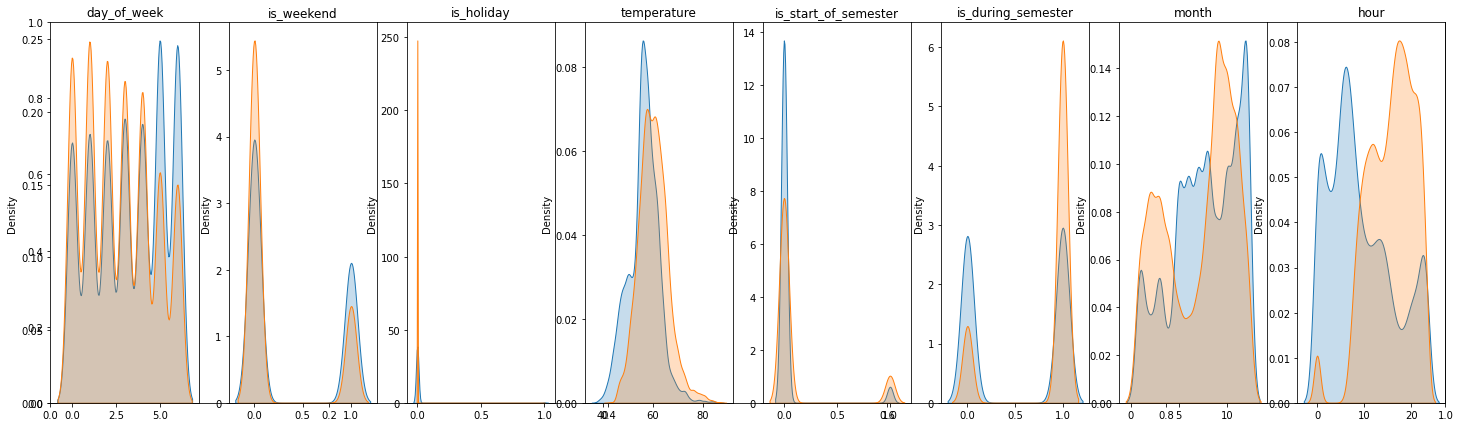

In [20]:
data = data.assign(crowded = data.number_people >= average_usercount).replace(True,1).replace(False,0)
data.drop(["number_people"],axis=1,inplace=True)
data.drop(["timestamp"],axis=1,inplace=True)
data["temperature"] = data["temperature"].astype(int)
data.drop(["date"],axis=1,inplace=True)
train_X, test_X, train_Y, test_Y = train_test_split(data.iloc[:,:-1],
                                                    data.iloc[:,-1],
                                                    test_size=0.4,
                                                    stratify = data.iloc[:,-1],
                                                    random_state=300)


#Train X -- Les attributs
# train Y c'est les classes

validation_X, test_x, validation_Y, test_y = train_test_split(test_X,
                                                              test_Y,
                                                              test_size=0.15/0.4,
                                                              stratify = test_Y,
                                                              random_state=300)
display("base divisée")


fig, ax = plt.subplots(figsize = (25,7))
for i, feature in enumerate(train_X.columns):
    axSub = fig.add_subplot(1, 8, i+1)
    axSub.set_title(feature)
    for s in train_Y.unique():
            sns.kdeplot(ax = axSub, data = train_X[train_Y == s].loc[:,feature].values, shade = True)
            




## ALGORTIHME

Nous aurons besoin de :
- Un Training set et ses classes associés (Train_X et Train_Y)
- Un threshold (Valeur entre 0 et 1, qui permettra à l'algorithme de s'arrêter)
    - Cette valeur existe pour pouvoir contrer l'over/underfitting et sera utilisée pour grapher le taux d'erreur du set de test par rapport au threshold 

- Déterminer Le plus bas Gini pour tout les attributs possibles en traversant toute les colonnes des entités
   - Si l'un d'entre eux est en dessous du threshold indiqué, alors on assigne une classe au noeud
       - Si plusieurs valeurs en font partie :
           - Si les valeurs appartiennent au même attribut, alors on fait un split les rassemblants toutes
           - Si les valeurs appartiennent à des attributs différents, alors on fait un split sur la valeur ayant le plus d'attributs (pour éviter d'avoir des splits sur des partitions trop petites)
   - Sinon, créer un noeud à partir de la partition ayant le plus petit indice, puis recommencer la boucle sur le subset


In [21]:
def calculate_gini_index(value, threshold):
    sum = value["1"] + value["0"]
    gini = 1-pow(value["1"]/sum,2)-pow(value["0"]/sum,2)
    return gini if gini > threshold else threshold

# Servira à récuperer le plus petit indice de Gini dans une list
def get_smallest_index_from_list(index_list):
    #1 est le chiffre le plus grand possible, à renvoyer en cas de liste vide
    tmp_value = 1
    new_list = {}
    
    if not index_list:
        return tmp_value
    for key in index_list:
        if index_list[key]["gini"] <= tmp_value:
            if index_list[key]["gini"] == tmp_value:
                new_list.update({key:index_list[key]})
            else:
                new_list = {key:index_list[key]}
                tmp_value = index_list[key]["gini"]
    return new_list

#e.g : {8:0} -- 8 avec un indice de 0
# Va retourner une liste de tout les plus petits indices pour cette catégorie
def get_smallest_gini(column, data, verif, threshold):
    
    bruh = {}
    best_splits = {}
    indices = data[column].index
    i = 0
    
    for row in data[column]:
        if str(row) not in bruh:
            bruh.update({str(row):{"0":0,"1":0}})
         #Recupère uniquement la colonne mentionnée + si la salle est bondée
        if verif[indices[i]] == 1:
            bruh[str(row)]["1"] = bruh[str(row)]["1"]+1
        else:
            bruh[str(row)]["0"] = bruh[str(row)]["0"]+1
        i=i+1
    # On itère sur les clés
    for key in bruh:
        bruh[key]["gini"] = calculate_gini_index(bruh[key],threshold)
    return get_smallest_index_from_list(bruh)


In [22]:
def get_rows_affected(gini_list):
    value = 0
    for i in gini_list:
        value = gini_list[i]["0"]+gini_list[i]["1"]
    return value

def get_ratio(gini_list):
    value_0 = 0
    value_1 = 0
    for i in gini_list:
        value_0 = value_0 + gini_list[i]['0']
        value_1 = value_1 + gini_list[i]['1']
    ratio0 = (value_0/value_0+value_1)
    ratio1 = (value_1/value_0+value_1)
    return ratio0 if ratio0 > ratio1 else ratio1

def get_most_interesting(list1,list2):
    fkey1, fkey2 = next(iter(list1)) , next(iter(list2))
    if list1[fkey1]["gini"] == list2[fkey2]["gini"]:
        if get_ratio(list1) == get_ratio(list2):
            return list1 if get_rows_affected(list1) >=  get_rows_affected(list2) else list2
        else:
            return  list1 if get_ratio(list1) > get_ratio(list2) else list2
    else:
        #print(list1[fkey1]["gini"],' face à ',list2[fkey2]["gini"])
        return list1 if list1[fkey1]["gini"] < list2[fkey2]["gini"] else list2

In [23]:
def get_smallest_ginis_overall(data, verif, threshold):
    #Il faut désormais trouver le split le plus intéressant (Plus de données traitées que les autres)
    best_overall = {}
    best_column = ''
    for column in data.columns:
        #print(column)
        best_gini_list = get_smallest_gini(column,data,verif,threshold)
        if not best_overall:
            best_overall = best_gini_list
            best_column = column
        elif get_most_interesting(best_overall, best_gini_list) == best_gini_list:
            best_overall = best_gini_list
            best_column = column
        #print("BEST GINIS AVAILABLE : ",column)
        #for i in best_gini_list:
            #print(i," ",best_gini_list[i])
        #TODO : Rajouter une fonction qui crée une coupe (liste des arguments,liste des valeurs à set 0 ou 1--on prend la valeur qui est la plus dominante)
    #print("BEST AVAILABLE SPLIT (",best_column,"):")
    #for i in best_overall:
        #print(i,' : ',best_overall[i])
    return {best_column:best_overall}


    

In [24]:
def get_majority(attributes):
    value_0 = 0
    value_1 = 0
    for i in attributes:
        value_0 = value_0 + attributes[i]['0']
        value_1 = value_1 + attributes[i]['1']
    #print("Majorité ","0"if value_0 > value_1 else "1"," : ",value_0," contre ",value_1 )
    return 0 if value_0 > value_1 else 1

In [25]:

a = []
for x in range(0,len(test_X)):
    a.append(-1)
a = np.array(a)

In [26]:
#retourne les valeurs valides
def split(test_X,array, column, attributes, value):
    for i in range(0,len(test_X)):
        for j in attributes:
            if test_X.iloc[i][column] == int(j):
                array[i] = value
                break
            else:
                if array[i] != -1:
                    break 
                array[i] = -1
    return array

def test_split(array,test_Y):
    wrong_values = 0
    assigned_values = 0
    for i in range(0,len(array)):
        if array[i] != -1:
            assigned_values = assigned_values + 1
        if array[i] != test_Y.iloc[i] and array[i] != -1:
            wrong_values = wrong_values+1
    return 100-((wrong_values/assigned_values)*100)
    #print(wrong_values ," erreurs trouvées pour ",assigned_values," valeurs assignées, pour une précision de ",100-((wrong_values/assigned_values)*100),"%")


In [27]:
def get_unassigned_values(array):
    for i in array:
        if array[i] == -1:
            return False
    return True

In [28]:
#utilisé à des fins de test
def remove_values_from_set(train_X,train_Y, column, attributes):
    remaining_data = train_X.copy()
    remaining_class_data = train_Y.copy()
    increment = 0
    for i in range(0,len(train_X)):
        for j in attributes:
            if train_X.iloc[i][column] == int(j):
                remaining_data = remaining_data.drop(remaining_data.index[i - increment])
                remaining_class_data = remaining_class_data.drop(remaining_class_data.index[i - increment])
                increment = increment + 1
                break
    #print("removed ",increment," values")
    return remaining_data,remaining_class_data


1807847  utilisateurs pour  62184  échantillons de donnés récoltés pour une moyenne de  29.072542776276855  utilisateurs à tout moment


'base divisée'

starting with threshold  7
Pour un threshold gini de  0  nous obtenons une précision fianle de  66.31851795380041
41
0.6785025086839058
              precision    recall  f1-score   support

           0       0.72      0.65      0.68      8244
           1       0.64      0.71      0.67      7302

    accuracy                           0.68     15546
   macro avg       0.68      0.68      0.68     15546
weighted avg       0.68      0.68      0.68     15546



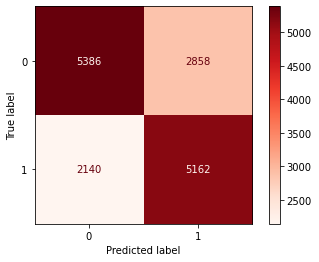

In [31]:
def initiate():
    data = pd.read_csv('../input/crowdedness-at-the-campus-gym/data.csv') # On charge le csv contenant les données
    sum_people = 0
    count = 0
    for value in data['number_people']:
        sum_people = sum_people + value
        count = count + 1
    average_usercount = sum_people/count
    print(sum_people," utilisateurs pour ",count," échantillons de donnés récoltés pour une moyenne de ",average_usercount," utilisateurs à tout moment")
    data = data.assign(crowded = data.number_people >= average_usercount).replace(True,1).replace(False,0)
    data.drop(["number_people"],axis=1,inplace=True)
    data.drop(["timestamp"],axis=1,inplace=True)
    data["temperature"] = data["temperature"].astype(int)
    data.drop(["date"],axis=1,inplace=True)
    train_X, test_X, train_Y, test_Y = train_test_split(data.iloc[:,:-1],
                                                    data.iloc[:,-1],
                                                    test_size=0.4,
                                                    stratify = data.iloc[:,-1],
                                                    random_state=300)


#Train X -- Les attributs
# train Y c'est les classes

    validation_X, test_x, validation_Y, test_y = train_test_split(test_X,
                                                              test_Y,
                                                              test_size=0.15/0.4,
                                                              stratify = test_Y,
                                                              random_state=300)
    display("base divisée")
    operations_dict = list()
    
    a = []
    for x in range(0,len(validation_X)):
        a.append(-1)
    a = np.array(a)
    cycle(train_X,train_Y,validation_X,validation_Y,a,operations_dict,0)


def display_cm(trX,trY,test_X, test_Y):
    clf = tree.DecisionTreeClassifier(random_state = 0)
    clf.fit(trX, trY)
    print(accuracy_score(test_Y, clf.predict(test_X), normalize=True))
    print(metrics.classification_report(test_Y, clf.predict(test_X)))
    disp = plot_confusion_matrix(clf,test_X, test_Y, display_labels = test_Y.unique(), cmap = plt.cm.Reds, normalize = None)
    display(disp)
    
def cycle(trX,trY,test_X,test_Y,a,operations_dict,threshold):
    while not get_unassigned_values(a):
        operations_dict.append(get_smallest_ginis_overall(trX,trY,threshold))
        a = split(test_X,a,next(iter(operations_dict[-1])),operations_dict[-1][next(iter(operations_dict[-1]))],get_majority(operations_dict[-1][next(iter(operations_dict[-1]))]))   
        test_split(a,test_Y)
        trX,trY = remove_values_from_set(trX,trY,next(iter(operations_dict[-1])),operations_dict[-1][next(iter(operations_dict[-1]))])
    print("Pour un threshold gini de ",threshold," nous obtenons une précision fianle de ",test_split(a,test_Y))
    print(len(operations_dict))
    display_cm(trX,trY,test_X,test_Y)




initiate()


In [ ]:
def show_plots(train_X,train_Y):
    fig, ax = plt.subplots(figsize = (25,7))
    for i, feature in enumerate(train_X.columns):
        axSub = fig.add_subplot(1, 9, i+1)
        axSub.set_title(feature)
        for s in train_Y.unique():
            sns.kdeplot(ax = axSub, data = train_X[train_Y == s].loc[:,feature].values, shade = True)
show_plots(train_X,train_Y)